In [1]:
from enum import Enum
import matplotlib.pyplot as plt

base = "/Users/gina/Documents/MIT/UROP/"

In [2]:
import ast
import os

class TimeValue(Enum):
    WP_DELAY = 'Write Propagation Delay'
    W_RMT = 'Write Remote'
    R_RMT = 'Read Remote'
    ID_SIZE = 'ID Size'
    DATA_SIZE = 'Data Size'
    SHARDS = 'Shards'
    UNSHARDED_MSG = 'Unsharded msgs/s'
    SHARDED_MSG = 'Sharded msgs/s'

class Result:
    all_wp = None
    wp_delay = None
    w_rmt = None
    r_rmt = None
    actual_ops = None
    
    id_size = None
    data_size = None
    n_sharded = None
    unsharded_msg = None
    sharded_msg = None
    
    def __init__(self, binary, target, sharding, truncate_every):
        self.binary = binary
        self.target = target
        self.sharding = sharding
        self.truncate_every = truncate_every
    
    def filename(self):
        return base + "noria_jerry/fault_tolerance_bm/results/{}-{}-{}-{}.txt".format(
            self.binary, self.target, self.sharding, self.truncate_every)
    
    def time(self, tv: TimeValue, index = 0):
        if tv == TimeValue.WP_DELAY:
            return self.wp_delay
        if tv == TimeValue.W_RMT:
            return self.w_rmt
        if tv == TimeValue.R_RMT:
            return self.r_rmt
        if tv == TimeValue.ID_SIZE:
            return self.id_size[index]
        if tv == TimeValue.DATA_SIZE:
            return self.data_size[index]
        if tv == TimeValue.SHARDS:
            return self.n_sharded[index]
        if tv == TimeValue.UNSHARDED_MSG:
            return self.unsharded_msg
        if tv == TimeValue.SHARDED_MSG:
            return self.sharded_msg
        return None
        
    def meets_target_ops(self, percent: int = 10) -> bool:
        ops_percent = int(1.0 * abs(self.actual_ops - self.target) / self.target * 100)
        if ops_percent > percent:
            print('{}, target {} ops/s off from actual {} ops/s by {}%'.format(
                self.filename(), self.target, self.actual_ops, ops_percent))
            return False
        else:
            return True

def parse(binary, target, sharding, truncate_every):
    result = Result(binary, target, sharding, truncate_every)
    filename = result.filename()
    try:
        with open(filename) as f:
            raw_data = f.read().split('\n')
            for i in range(len(raw_data)):
                line = raw_data[i]
                
                # Sharder metadata
                if line.startswith('Size of packet id:'):
                    result.id_size = ast.literal_eval(line.split(':')[1].strip())
                elif line.startswith('Size of packet data:'):
                    result.data_size = ast.literal_eval(line.split(':')[1].strip())
                elif line.startswith('Num shards by author_id:'):
                    result.n_sharded = ast.literal_eval(line.split(':')[1].strip())
                elif 'sharded' in line:
                    messages_pms = int(line.split()[-4])
                    if 'unsharded' in line:
                        result.unsharded_msg = messages_pms
                    else:
                        result.sharded_msg = messages_pms

                # Final histogram
                if not line.startswith('(relative write time (ms since start), delay (us))'):
                    continue
                result.all_wp = ast.literal_eval(raw_data[i + 1])
                result.wp_delay = int(raw_data[i + 2].split()[-2])
                result.actual_ops = float(raw_data[i + 8].split()[-1])
                result.w_rmt = int(raw_data[i + 10].split()[-3])
                result.r_rmt = int(raw_data[i + 11].split()[-3])
                return result
        print('could not parse: ' + filename)
    except Exception as e:
        print('error parsing: ' + filename)
        print(e)

def parse_all_results():
    results = []
    for filename in os.listdir(base + 'noria_jerry/fault_tolerance_bm/results/'):
        tmp = filename[:-4].split('-')
        result = parse(str(tmp[0]), int(tmp[1]), int(tmp[2]), int(tmp[3]))
        if result is None:
            continue
        result.meets_target_ops()
        results.append(result)
    return results


In [3]:
def plot_internal(plt, title, left, right, top, bottom, x_interval, y_interval):
    if left is not None:
        plt.xlim(left = left)
    if right is not None:
        plt.xlim(right = right)
    if bottom is not None:
        plt.ylim(bottom = bottom)
    if top is not None:
        plt.ylim(top = top)
    if x_interval is not None:
        left, right = plt.xlim()
        plt.xticks(range(int(left), int(right), int(x_interval)))
    if y_interval is not None:
        bottom, top = plt.ylim()
        plt.yticks(range(int(bottom), int(top), int(y_interval)))
        
    plt.title(title)
    plt.legend()
    plt.show()


In [4]:
"""
Index results
"""
BINARY_TARGET_SHARDS_TRUNC = {}

def index_results():
    BINARY_TARGET_SHARDS_TRUNC.clear()
    results = parse_all_results()
    for result in results:
        binary = result.binary
        target = result.target
        shards = result.sharding
        trunc = result.truncate_every

        if binary not in BINARY_TARGET_SHARDS_TRUNC:
            BINARY_TARGET_SHARDS_TRUNC[binary] = {}
        if target not in BINARY_TARGET_SHARDS_TRUNC[binary]:
            BINARY_TARGET_SHARDS_TRUNC[binary][target] = {}
        if shards not in BINARY_TARGET_SHARDS_TRUNC[binary][target]:
            BINARY_TARGET_SHARDS_TRUNC[binary][target][shards] = {}
        BINARY_TARGET_SHARDS_TRUNC[binary][target][shards][trunc] = result

def get_result(binary, target, sharding, trunc, verbose=False):
    if binary != 'ft':
        trunc = 1
    filename = "{}-{}-{}-{}.txt".format(binary, target, sharding, trunc)
    if binary in BINARY_TARGET_SHARDS_TRUNC:
        if target in BINARY_TARGET_SHARDS_TRUNC[binary]:
            if sharding in BINARY_TARGET_SHARDS_TRUNC[binary][target]:
                if trunc in BINARY_TARGET_SHARDS_TRUNC[binary][target][sharding]:
                    return BINARY_TARGET_SHARDS_TRUNC[binary][target][sharding][trunc]
                elif verbose:
                    print("{} truncate-every does not exist".format(filename))
            elif verbose:
                print("{} shards does not exist".format(filename))
        elif verbose:
            print("{} target does not exist".format(filename))
    elif verbose:
        print("{} binary does not exist".format(filename))

index_results()

could not parse: /Users/gina/Documents/MIT/UROP/noria_jerry/fault_tolerance_bm/results/ft-1800000-20-2.txt
could not parse: /Users/gina/Documents/MIT/UROP/noria_jerry/fault_tolerance_bm/results/master-2400000-20-1.txt
could not parse: /Users/gina/Documents/MIT/UROP/noria_jerry/fault_tolerance_bm/results/master-2200000-20-1.txt
could not parse: /Users/gina/Documents/MIT/UROP/noria_jerry/fault_tolerance_bm/results/master-2000000-20-1.txt
could not parse: /Users/gina/Documents/MIT/UROP/noria_jerry/fault_tolerance_bm/results/master-2300000-20-1.txt
could not parse: /Users/gina/Documents/MIT/UROP/noria_jerry/fault_tolerance_bm/results/master-500000-20-1.txt
could not parse: /Users/gina/Documents/MIT/UROP/noria_jerry/fault_tolerance_bm/results/master-2900000-20-1.txt
could not parse: /Users/gina/Documents/MIT/UROP/noria_jerry/fault_tolerance_bm/results/master-2500000-20-1.txt
could not parse: /Users/gina/Documents/MIT/UROP/noria_jerry/fault_tolerance_bm/results/master-2700000-20-1.txt
could 

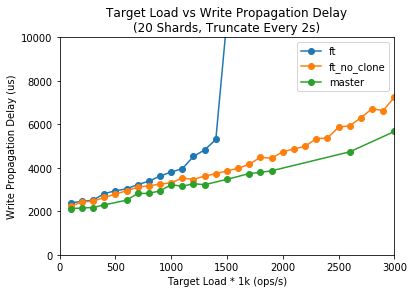

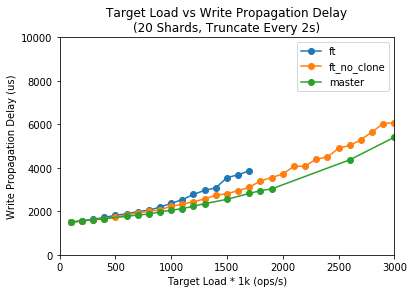

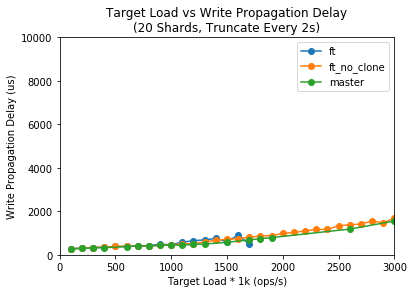

In [15]:
def plot_value_vs_time(
    targets,
    fn = lambda x: x.time(TimeValue.WP_DELAY),
    binaries = ['master', 'ft'],
    sharding: int = 10,
    truncate_every: int = 2,
    verbose=False,
    left=0, right=None, top=None, bottom=None, x_interval=None, y_interval=None
):
    title = 'Target Load vs {}\n({} Shards, Truncate Every {}s)'.format(time.value, sharding, truncate_every)
    plt.xlabel('Target Load * 1k (ops/s)')
    plt.ylabel('{} (us)'.format(time.value))

    for binary in binaries:
        x = []
        y = []
        for target in targets:
            result = get_result(binary, target, sharding, truncate_every)
            if result is None:
                continue
            x.append(target / 1000)
            y.append(fn(result))
        plt.plot(x, y, label=binary, marker='o')
        if verbose:
            print([n for n in zip(x, y)])
    plot_internal(plt, title, left, right, top, bottom, x_interval, y_interval)

# index_results()
right = 3000
binaries = ['ft', 'ft_no_clone', 'master']
targets = [i * 100000 for i in range(1, 40)]
# plot_value_vs_time(targets, sharding=1, right=right, top=25000, bottom=0)
# plot_value_vs_time(targets, sharding=4, right=right, top=25000, bottom=0, binaries=binaries)
# plot_value_vs_time(targets, sharding=10, right=right, top=25000, bottom=0, binaries=binaries)
plot_value_vs_time(targets, lambda x: x.time(TimeValue.WP_DELAY), sharding=20, right=right, top=10000, bottom=0, binaries=binaries)
plot_value_vs_time(targets, lambda x: x.time(TimeValue.W_RMT), sharding=20, right=right, top=10000, bottom=0, binaries=binaries)
plot_value_vs_time(targets, lambda x: x.time(TimeValue.R_RMT), sharding=20, right=right, top=10000, bottom=0, binaries=binaries)
# plot_value_vs_time(targets, sharding=50, right=right, top=25000, bottom=0, binaries=binaries)
# plot_value_vs_time(targets, sharding=10, bottom=0)

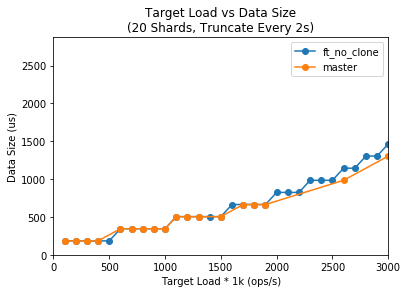

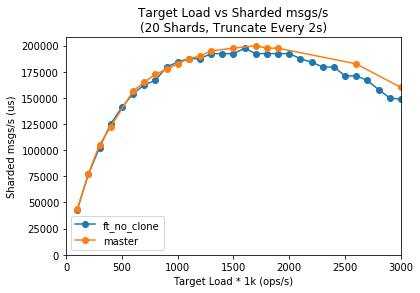

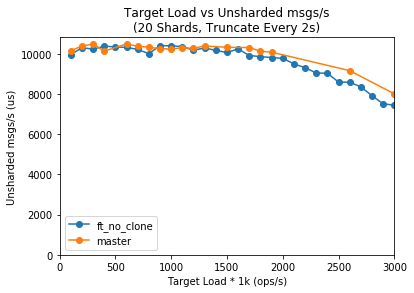

In [14]:
binaries=['ft_no_clone','master']
targets=[i * 100000 for i in range(1, 40)]

# plot_value_vs_time(binaries=['ft'], targets=targets, time=TimeValue.ID_SIZE, sharding=20, right=right, bottom=0)
plot_value_vs_time(binaries=binaries, targets=targets, time=TimeValue.DATA_SIZE, sharding=20, right=right, bottom=0)
# plot_value_vs_time(binaries=['ft'], targets=targets, time=TimeValue.SHARDS, sharding=20, right=right, bottom=0)
plot_value_vs_time(binaries=binaries, targets=targets, time=TimeValue.SHARDED_MSG, sharding=20, right=right, bottom=0)
plot_value_vs_time(binaries=binaries, targets=targets, time=TimeValue.UNSHARDED_MSG, sharding=20, right=right, bottom=0)
# plot_value_vs_time(binaries=binaries, targets=targets, fn=lambda x: (x.time(TimeValue.UNSHARDED_MSG) + 2 * x.time(TimeValue.SHARDED_MSG))/3.0, sharding=20, right=right, bottom=0)
# plot_value_vs_time(binaries=binaries, targets=targets, fn=lambda x: (x.time(TimeValue.UNSHARDED_MSG) + 5 * x.time(TimeValue.SHARDED_MSG))/6.0, sharding=20, right=right, bottom=0)

In [16]:
# def plot_truncate_every_vs_time(
#     truncate_every,
#     shards,
#     time: TimeValue = TimeValue.W_RMT,
#     target: int = 100000,
#     left=0, right=None, top=None, bottom=None, x_interval=None, y_interval=None
# ):
#     title = 'Truncate Every vs {} ({} ops/s)'.format(time.value, target)
#     plt.xlabel('Truncation Interval (s)')
#     plt.ylabel('{} (us)'.format(time.value))

#     binary = "ft"
#     for shard in shards:
#         x = []
#         y = []
#         for trunc in truncate_every:
#             result = get_result(binary, target, shard, trunc)
#             if result is None:
#                 continue
#             x.append(trunc)
#             y.append(result.time(time))
#         plt.plot(x, y, marker='o', label="{} shards".format(shard))
#     plot_internal(plt, title, left, right, top, bottom, x_interval, y_interval)        
    
# # index_results()
# truncate_every = [1,2,4,8]
# shards = [10, 20]
# target = 1000000
# plot_truncate_every_vs_time(truncate_every, shards, time=TimeValue.WP_DELAY, target=target, bottom=0, x_interval=1)

In [17]:
# def plot_shards_vs_time(
#     sharding,
#     binaries = ['master', 'ft'],
#     time: TimeValue = TimeValue.WP_DELAY,
#     target: int = 200000,
#     truncate_every: int = 2,
#     left=0, right=None, top=None, bottom=None, x_interval=None, y_interval=None
# ):
#     title = 'Shards vs {} ({} ops/s, Truncate Every {}s)'.format(time.value, target, truncate_every)
#     plt.xlabel('Num Shards')
#     plt.ylabel('{} (us)'.format(time.value))

#     for binary in binaries:
#         x = []
#         y = []
#         for shards in sharding:
#             result = get_result(binary, target, shards, truncate_every)
#             if result is None:
#                 continue
#             x.append(shards)
#             y.append(result.time(time))
#         plt.plot(x, y, marker='o', label=binary)
#     plot_internal(plt, title, left, right, top, bottom, x_interval, y_interval)
    
# index_results()
# sharding = [1, 2, 4, 8, 10]
# plot_shards_vs_time(sharding, bottom=0)

No handles with labels found to put in legend.


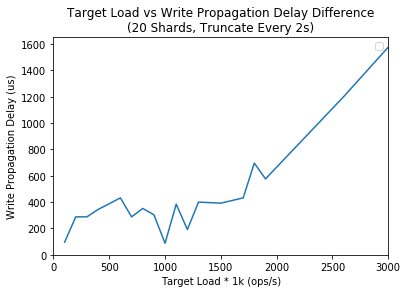

In [19]:
def plot_value_vs_time_diff(
    targets,
    binaries = ['master', 'ft'],
    time: TimeValue = TimeValue.WP_DELAY,
    sharding: int = 10,
    truncate_every: int = 2,
    left=0, right=None, top=None, bottom=None, x_interval=None, y_interval=None
):
    title = 'Target Load vs {} Difference\n({} Shards, Truncate Every {}s)'.format(time.value, sharding, truncate_every)
    plt.xlabel('Target Load * 1k (ops/s)')
    plt.ylabel('{} (us)'.format(time.value))

    x = []
    y = []
    for target in targets:
        result1 = get_result(binaries[0], target, sharding, truncate_every)
        result2 = get_result(binaries[1], target, sharding, truncate_every)
        if result1 is None or result2 is None:
            continue
        x.append(target / 1000)
        y.append(result1.time(time) - result2.time(time))
    plt.plot(x, y)
    plot_internal(plt, title, left, right, top, bottom, x_interval, y_interval)

# index_results()
time = TimeValue.WP_DELAY
right = 3000
binaries = ['ft_no_clone', 'master']
plot_value_vs_time_diff(targets = [i * 100000 for i in range(1, 40)], time=time, sharding=20, right=right, bottom=0, binaries=binaries)

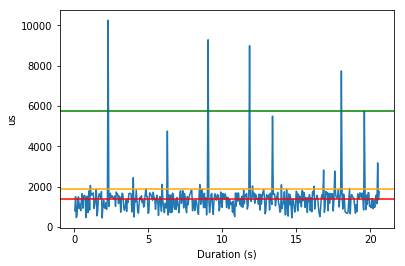

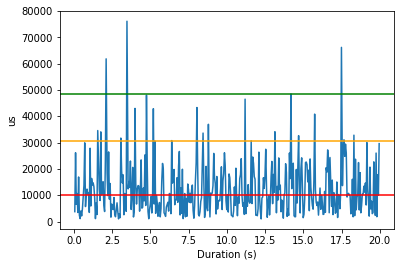

In [20]:
"""
Raw write propagation time data from a single output file.
Bursty because of log truncation.
Horizontal lines indicate write propagation at the 50th, 95th, 99th percentiles.
"""
def plot(data):
    plt.xlabel('Duration (s)')
    plt.ylabel('us')
    x=[pt[0]/1000. for pt in data]
    y=[pt[1] for pt in data]
    plt.plot(x, y)
    
    sorted_y = [pt for pt in y]
    sorted_y.sort()
    plt.axhline(sorted_y[int(len(y)*.5)], color='red')
    plt.axhline(sorted_y[int(len(y)*.95)], color='orange')
    plt.axhline(sorted_y[int(len(y)*.99)], color='green')
    plt.show()
    

ops_100k=[[49,803],[99,1504],[149,466],[199,551],[249,1376],[299,1494],[349,911],[399,1126],[449,805],[499,1397],[549,1646],[599,932],[649,1535],[699,1570],[749,1501],[799,468],[850,1484],[900,1526],[950,708],[1000,1786],[1050,837],[1100,2053],[1150,1583],[1200,1588],[1250,1655],[1300,1691],[1350,918],[1400,1111],[1450,1414],[1500,1881],[1550,549],[1600,819],[1650,1504],[1700,1647],[1750,1534],[1800,1411],[1850,1756],[1900,448],[1950,1083],[2000,1316],[2050,956],[2100,922],[2150,1199],[2200,880],[2250,1441],[2300,10251],[2350,1016],[2400,1621],[2450,1667],[2500,1459],[2550,1552],[2600,1524],[2650,1402],[2700,1407],[2750,1536],[2800,1018],[2850,1735],[2900,1605],[2950,1629],[3000,1160],[3050,1531],[3100,1487],[3150,732],[3200,1396],[3250,1671],[3300,1608],[3350,1006],[3400,827],[3450,993],[3500,1331],[3550,765],[3600,1372],[3650,1215],[3700,1647],[3750,1657],[3800,1669],[3850,1643],[3900,740],[3950,1285],[4000,2445],[4050,491],[4100,1362],[4150,1244],[4200,1829],[4250,1330],[4300,770],[4350,684],[4400,1220],[4450,1465],[4500,1354],[4550,1547],[4600,1208],[4650,1322],[4700,987],[4750,1061],[4800,1595],[4850,1905],[4900,1514],[4950,1504],[5000,677],[5050,736],[5100,1692],[5150,1655],[5200,1582],[5250,1460],[5300,1324],[5350,1724],[5400,1396],[5450,1441],[5500,876],[5550,1326],[5600,1574],[5650,1339],[5700,569],[5750,1217],[5800,1508],[5850,1226],[5900,777],[5950,2116],[6000,1259],[6050,959],[6100,707],[6150,1174],[6200,1105],[6250,934],[6300,4755],[6350,589],[6400,1595],[6450,1359],[6500,703],[6550,1589],[6600,727],[6650,1675],[6700,1602],[6750,981],[6800,877],[6851,1358],[6901,879],[6951,1456],[7001,1191],[7051,981],[7101,705],[7151,1740],[7201,1794],[7251,1174],[7301,1454],[7351,1794],[7401,942],[7451,1657],[7501,1496],[7551,894],[7601,708],[7651,1505],[7701,1093],[7751,1412],[7801,1587],[7851,1663],[7901,1804],[7951,1811],[8001,805],[8051,1193],[8101,1309],[8151,810],[8201,1150],[8251,1340],[8301,1086],[8351,820],[8401,622],[8451,1717],[8501,2097],[8551,1124],[8601,1705],[8651,1873],[8701,1274],[8751,950],[8801,1666],[8851,971],[8901,1440],[8951,596],[9001,1524],[9051,9281],[9101,1350],[9151,709],[9201,1112],[9251,1608],[9301,1659],[9351,980],[9401,621],[9451,1349],[9501,1640],[9551,1620],[9601,1327],[9651,1454],[9701,1605],[9751,1473],[9801,800],[9851,988],[9901,1734],[9951,1295],[10001,973],[10051,1658],[10101,1546],[10151,1385],[10201,1643],[10251,1519],[10301,954],[10351,1469],[10401,1461],[10451,903],[10501,1374],[10551,1096],[10601,1215],[10651,1207],[10701,733],[10751,1288],[10801,647],[10851,514],[10901,1682],[10951,1036],[11001,1680],[11051,1289],[11101,1688],[11151,1338],[11201,1113],[11251,1415],[11301,1007],[11351,1529],[11401,979],[11451,1825],[11501,1154],[11551,1604],[11601,1542],[11651,1656],[11701,885],[11751,1074],[11801,1711],[11851,8990],[11901,1465],[11951,1267],[12001,1431],[12051,2034],[12101,1497],[12151,1680],[12201,1177],[12251,1626],[12301,1531],[12351,1369],[12401,1411],[12451,1129],[12501,1627],[12551,838],[12601,1617],[12651,1133],[12701,1488],[12751,1720],[12802,1851],[12852,1515],[12902,654],[12952,796],[13002,1599],[13052,1441],[13102,1527],[13152,1588],[13202,841],[13252,1679],[13302,1512],[13352,1112],[13402,5494],[13452,1615],[13502,1651],[13552,1607],[13602,1048],[13652,1380],[13702,1519],[13752,1719],[13802,1219],[13852,1080],[13902,733],[13952,788],[14002,2091],[14052,916],[14102,1162],[14152,1196],[14202,1746],[14252,600],[14302,617],[14352,1881],[14402,1123],[14452,537],[14502,1638],[14552,1098],[14602,1591],[14652,1100],[14702,449],[14752,1379],[14802,1363],[14852,1046],[14902,737],[14952,940],[15002,1770],[15052,1727],[15102,794],[15152,1628],[15202,1202],[15252,1526],[15302,1334],[15352,995],[15402,1800],[15452,1293],[15502,1733],[15552,1668],[15602,968],[15652,1457],[15702,1336],[15752,720],[15802,1461],[15852,1257],[15902,1607],[15952,800],[16002,1442],[16052,751],[16102,1742],[16152,1596],[16202,2022],[16252,887],[16302,1319],[16352,1404],[16402,1571],[16452,1452],[16502,974],[16552,667],[16602,512],[16652,948],[16702,1504],[16752,1604],[16802,1425],[16852,2820],[16902,720],[16952,984],[17002,1761],[17052,1633],[17102,1706],[17152,801],[17202,1671],[17252,1170],[17302,1443],[17352,1653],[17402,1407],[17452,1642],[17502,793],[17552,1404],[17602,2773],[17652,1704],[17702,1473],[17752,1437],[17802,1485],[17852,1853],[17902,988],[17952,1466],[18002,1639],[18052,7736],[18102,1531],[18152,887],[18202,1631],[18252,1433],[18302,750],[18352,719],[18402,718],[18453,668],[18503,764],[18553,1364],[18603,1918],[18653,650],[18703,1493],[18753,1603],[18803,1499],[18853,1456],[18903,1423],[18953,977],[19003,682],[19053,1105],[19103,766],[19153,1643],[19203,1543],[19253,1385],[19303,1691],[19353,1551],[19403,1470],[19453,1685],[19503,1452],[19553,843],[19603,5734],[19653,1641],[19703,861],[19753,1581],[19803,1126],[19853,1687],[19903,1701],[19953,1023],[20003,1042],[20053,952],[20103,1413],[20153,1196],[20203,901],[20253,1304],[20303,973],[20353,1359],[20403,1577],[20453,1145],[20503,3176],[20553,1346],[20603,1752]]
ops_400k=[[49,3794],[99,26183],[149,6588],[199,10687],[249,3477],[299,16964],[349,2387],[399,1145],[449,4070],[499,2191],[549,4928],[599,9194],[649,13868],[699,29938],[749,5723],[799,10275],[849,12363],[899,10446],[949,11017],[999,3499],[1049,27894],[1099,5936],[1149,16421],[1200,13907],[1250,14746],[1300,13281],[1350,8947],[1400,1141],[1450,7113],[1500,2696],[1550,34605],[1600,22944],[1650,12298],[1700,8029],[1750,34106],[1800,10164],[1850,13366],[1900,15161],[1950,6229],[2000,3838],[2050,23646],[2100,61855],[2162,18546],[2212,9892],[2262,26482],[2312,8543],[2362,14492],[2412,1700],[2462,6643],[2512,5353],[2562,4587],[2612,9182],[2662,2648],[2712,1853],[2762,4669],[2812,7152],[2862,3855],[2912,1055],[2962,3001],[3012,1509],[3062,31755],[3112,19257],[3162,14662],[3212,17774],[3262,2604],[3312,10688],[3362,6728],[3412,3914],[3462,76142],[3538,12429],[3588,15223],[3638,12975],[3688,23020],[3738,4629],[3788,9957],[3838,20614],[3888,1770],[3938,4025],[3988,43025],[4038,14534],[4088,6682],[4138,12339],[4189,13723],[4239,13516],[4289,3983],[4339,11326],[4389,23451],[4439,5123],[4489,5456],[4539,12814],[4589,7888],[4639,25353],[4689,6139],[4739,48036],[4789,21151],[4839,3831],[4889,1100],[4939,4651],[4989,6535],[5039,9523],[5089,3283],[5139,9769],[5189,42917],[5239,6701],[5289,30626],[5339,3141],[5389,9958],[5439,7363],[5489,2047],[5539,5414],[5589,7268],[5639,1823],[5689,4957],[5739,15507],[5789,22114],[5839,20022],[5889,3352],[5939,2807],[5989,1988],[6039,5520],[6089,6474],[6139,7355],[6189,4000],[6239,10703],[6289,9959],[6339,3016],[6389,30798],[6439,14634],[6489,16932],[6539,19817],[6589,6425],[6639,8356],[6689,8244],[6739,16688],[6789,7358],[6839,21159],[6889,26664],[6939,2532],[6989,12876],[7039,3132],[7089,19906],[7139,1145],[7189,4475],[7239,10677],[7289,1829],[7339,8796],[7389,2064],[7439,14293],[7489,12117],[7539,7309],[7589,10769],[7639,7174],[7689,12032],[7739,13895],[7789,4322],[7839,1309],[7889,6020],[7939,15418],[7989,22243],[8039,43362],[8089,19986],[8139,2756],[8190,2144],[8240,3804],[8290,7662],[8340,9097],[8390,22201],[8440,33653],[8490,15613],[8540,1591],[8590,3772],[8640,20998],[8690,5417],[8740,4170],[8790,36986],[8840,10830],[8890,1782],[8940,10862],[8990,10546],[9040,10861],[9090,13681],[9140,25934],[9190,16798],[9240,14404],[9290,2905],[9340,17161],[9390,4786],[9440,7643],[9490,8091],[9540,7924],[9590,12752],[9640,20828],[9690,4589],[9740,15535],[9790,18257],[9840,26165],[9890,21265],[9940,7967],[9990,4558],[10040,10249],[10090,3641],[10140,18122],[10190,16673],[10240,10926],[10290,2411],[10340,2238],[10390,1829],[10440,4039],[10490,13168],[10540,6172],[10590,20306],[10640,8118],[10690,2251],[10740,9410],[10790,6975],[10840,16342],[10890,17891],[10940,23930],[10990,9537],[11040,5838],[11090,7045],[11140,2745],[11190,46539],[11240,3008],[11290,10215],[11340,5836],[11390,14039],[11440,7939],[11490,7029],[11540,7544],[11590,30711],[11641,6869],[11691,24552],[11741,22172],[11791,17108],[11841,16159],[11891,2420],[11941,2508],[11991,2254],[12041,4908],[12091,26404],[12141,8978],[12191,3842],[12241,1033],[12291,8943],[12341,9390],[12391,16677],[12441,12615],[12491,17171],[12541,27513],[12591,13470],[12641,1637],[12691,7280],[12741,9807],[12791,2537],[12841,7966],[12891,17100],[12941,22882],[12991,6832],[13041,17941],[13091,11075],[13141,34159],[13191,15835],[13241,3364],[13291,13393],[13341,8203],[13392,24205],[13442,12208],[13492,13875],[13542,3752],[13592,8176],[13642,7704],[13692,1320],[13742,10177],[13792,10863],[13842,22003],[13892,18658],[13942,1980],[13992,4818],[14042,2362],[14092,26074],[14142,16362],[14192,48518],[14242,12530],[14292,21695],[14342,22192],[14392,2244],[14442,1848],[14492,1866],[14542,19828],[14592,7066],[14642,20886],[14692,32674],[14742,12573],[14792,3301],[14842,20001],[14892,24235],[14942,12673],[14992,1498],[15042,2743],[15092,8712],[15142,22471],[15192,22643],[15242,21596],[15292,15096],[15342,19537],[15392,4151],[15442,23821],[15492,13085],[15542,9216],[15592,6129],[15642,4734],[15692,15829],[15742,40857],[15792,12037],[15842,7344],[15892,6136],[15942,7468],[15992,2479],[16042,7684],[16092,12763],[16142,4674],[16193,9990],[16243,7298],[16293,2731],[16343,2842],[16393,11482],[16443,3528],[16493,20486],[16543,18798],[16593,27253],[16643,23678],[16693,3371],[16743,24372],[16793,14841],[16843,5780],[16893,15787],[16943,2653],[16993,11023],[17043,8390],[17093,3190],[17143,3654],[17193,15070],[17244,1566],[17294,10287],[17344,9852],[17394,4901],[17444,11000],[17494,66213],[17560,13675],[17610,27384],[17660,31075],[17710,24825],[17760,29459],[17810,26067],[17860,9345],[17910,10574],[17960,10745],[18010,10165],[18060,9784],[18110,2962],[18160,5724],[18210,16102],[18260,1840],[18310,32854],[18360,2248],[18411,23721],[18461,4482],[18511,9304],[18561,10192],[18611,22445],[18661,4424],[18711,18629],[18761,3349],[18811,6090],[18861,10405],[18911,10423],[18961,13459],[19011,11208],[19061,14675],[19111,6321],[19161,30010],[19211,12397],[19261,8055],[19311,2099],[19361,20718],[19411,4812],[19461,7800],[19511,3030],[19561,3450],[19611,22709],[19661,8831],[19711,2367],[19761,26050],[19811,1860],[19861,17767],[19911,9987],[19961,29637]]
plot(ops_100k)
plot(ops_400k)